In [1]:
# % because of separate env
%pip install numpy pandas matplotlib opencv-python torch torchvision tqdm cv2

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm


import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable


Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)

[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: No matching distribution found for cv2


In [2]:
TRAIN_DIR = r"E:\THIRD YEAR\Datasets\deepglobe\smallSizeTrain"
VALID_DIR = r"E:\THIRD YEAR\Datasets\deepglobe\smallSizeValid"
TEST_DIR = r"E:\THIRD YEAR\Datasets\deepglobe\smallSizeTest"
COLOR_CODES = r"E:\THIRD YEAR\Datasets\deepglobe\class_dict.csv"

# Transformation(resizing & tensor conversion)
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256))
])

#! while performing semantic segmentation, nearest neighbor interpolation is necessary to maintain the integrity of class labels. If you were using bilinear or bicubic interpolation, class values would be altered, leading to incorrect training labels.
mask_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((256, 256), interpolation=transforms.InterpolationMode.NEAREST)
])

In [3]:
df = pd.read_csv(COLOR_CODES)
label_map = {}
for index, row in df.iterrows():
    label_map[index] = [row["r"],row["g"],row["b"]]
label_map

{0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

In [3]:
import os
import cv2
import numpy as np
from torch.utils.data import Dataset

class Segmentation_Dataset(Dataset):
    def __init__(self, image_dir, label_map, image_transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.image_transform = image_transform
        self.mask_transform = mask_transform
        self.original_label_map = label_map  # Keep original for reference
        
        # If keys are not integers, create a mapping from class names to numeric indices.
        if not all(isinstance(k, int) for k in label_map.keys()):
            # Create a mapping dictionary based on sorted order of keys (or a predefined order if you have one)
            self.name_to_index = {name: idx for idx, name in enumerate(sorted(label_map.keys()))}
            # Update label_map to have integer keys
            self.label_map = {self.name_to_index[name]: color for name, color in label_map.items()}
            print("Converted label_map keys to integers using mapping:", self.name_to_index)
        else:
            self.label_map = label_map
            self.name_to_index = None

        self.images_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_sat.jpg')])
        self.targets_name = sorted([filename for filename in os.listdir(self.image_dir) if filename.endswith('_mask.png')])
        
        # Debug prints
        print(f'Number of images: {len(self.images_name)}')
        print(f'Number of masks: {len(self.targets_name)}')

    def __len__(self):
        return len(self.images_name)

    def __getitem__(self, idx):
        if idx >= len(self.images_name) or idx >= len(self.targets_name):
            raise IndexError(f'Index {idx} out of range. Lengths are {len(self.images_name)} for images and {len(self.targets_name)} for masks.')
        
        image_path = os.path.join(self.image_dir, self.images_name[idx])
        mask_path = os.path.join(self.image_dir, self.targets_name[idx])
        
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # convert to RGB
        
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)  # convert to RGB
        mask = self.colormap_to_labelmap(mask)

        if self.image_transform:
            image = self.image_transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)
            
        return image, mask
    
    def colormap_to_labelmap(self, mask):
        """
        Converts an RGB mask to a 2D label map (each pixel's value is the class index)
        """
        # Create an empty output array
        label_image = np.zeros(mask.shape[:2], dtype=np.uint8)
        # No need to convert mask again since it is already in RGB
        mask_reshaped = mask.reshape(-1, 3)
        label_image_flat = np.zeros(mask_reshaped.shape[0], dtype=np.uint8)

        # Optional: Debug print first few pixels
        print("Sample mask pixels:", mask_reshaped[:5])

        # For each class label and its corresponding color, assign pixels
        for label, color in self.label_map.items():
            color = np.array(color)
            match_pixels = np.all(mask_reshaped == color, axis=1)
            # Ensure that label is an integer (it should be after our conversion)
            label_image_flat[match_pixels] = int(label)

        return label_image_flat.reshape(mask.shape[:2]).astype(np.int64)  # Ensure output is int64


In [35]:
# TESTING - seems to be working fine
mask_path = 'E:\\THIRD YEAR\\Datasets\\deepglobe\\train\\27460_mask.png'
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
print(os.path.exists(mask_path))

if len(mask.shape) == 2:  # !Grayscale
    print("Warning: The mask is grayscale, not RGB. Check if label_map is compatible.")

# Flatten the mask and get unique colors
unique_colors = np.unique(mask.reshape(-1, 3), axis=0)

# Check if each color is in the label_map
for color in unique_colors:
    if not any(np.array_equal(color, np.array(c)) for c in label_map.values()):
        print(f"Color {color} is not in the label_map")
    else:
        print('"fine"')

True
"fine"
"fine"
"fine"
"fine"


In [8]:
"""img, mask, bla = Segmentation_Dataset(TRAIN_DIR, label_map).__getitem__(0)
print(bla)
sample = [img, mask]
for i in range(len(sample)):
    plt.subplot(1, 2, i+1)
    plt.imshow(sample[i])
    plt.axis('off')
plt.show()"""

"img, mask, bla = Segmentation_Dataset(TRAIN_DIR, label_map).__getitem__(0)\nprint(bla)\nsample = [img, mask]\nfor i in range(len(sample)):\n    plt.subplot(1, 2, i+1)\n    plt.imshow(sample[i])\n    plt.axis('off')\nplt.show()"

In [23]:
Prev version(not confirmed to be redundant)
Trying changes below

# class ResidualBlock(nn.Module):
#     def __init__(self, in_c=3, out_c=1):
#         super(ResidualBlock, self).__init__()
#         self.conv = nn.Sequential(
#             nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(out_c),
#             nn.LeakyReLU(negative_slope=0.1, inplace=True),
#             nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1),
#             nn.BatchNorm2d(out_c),
#             nn.LeakyReLU(negative_slope=0.1, inplace=True)
#         )
#         self.skip = nn.Sequential(
#             nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0),
#             nn.BatchNorm2d(out_c),
#             nn.LeakyReLU(negative_slope=0.1, inplace=True)
#         )

#     def forward(self, x):
#         conv = self.conv(x)
#         skip = self.skip(x)

#         plus = conv + skip
#         return plus

# class UNet(nn.Module):

#     def __init__(self, n_class):
#         super().__init__()
                
#         self.dconv_down1 = ResidualBlock(3, 64)
#         self.dconv_down2 = ResidualBlock(64, 128)
#         self.dconv_down3 = ResidualBlock(128, 256)
#         self.dconv_down4 = ResidualBlock(256,512)
#         self.bottleneck = ResidualBlock(512, 1024)        

#         self.maxpool = nn.MaxPool2d(2)

#         self.dconv1 =  nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)        
#         self.dconv2 =  nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
#         self.dconv3 =  nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
#         self.dconv4 =  nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)

#         self.dconv_up4 = ResidualBlock(1024, 512) 
#         self.dconv_up3 = ResidualBlock(512, 256)
#         self.dconv_up2 = ResidualBlock(256, 128)
#         self.dconv_up1 = ResidualBlock(128, 64)
#         self.conv_last = nn.Conv2d(64, n_class, 1)
        
        
#     def forward(self, x):

#         # encoder
#         conv1 = self.dconv_down1(x)
#         x1 = self.maxpool(conv1) 

#         conv2 = self.dconv_down2(x1)
#         x2 = self.maxpool(conv2) 
        
#         conv3 = self.dconv_down3(x2)
#         x3 = self.maxpool(conv3) 

#         conv4 = self.dconv_down4(x3)
#         x4 = self.maxpool(conv4)         

#         x5 = self.bottleneck(x4) 


#         x = self.dconv1(x5)        
#         x = torch.cat([x, conv4], dim=1)
#         x = self.dconv_up4(x)

#         x = self.dconv2(x)        
#         x = torch.cat([x, conv3], dim=1)       
#         x = self.dconv_up3(x)

#         x = self.dconv3(x)        
#         x = torch.cat([x, conv2], dim=1)   
#         x = self.dconv_up2(x)

#         x = self.dconv4(x)        
#         x = torch.cat([x, conv1], dim=1)   
#         x = self.dconv_up1(x)
        
#         seg = self.conv_last(x)

#         return seg


SyntaxError: invalid syntax (1457093995.py, line 1)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
            nn.LeakyReLU(negative_slope=0.1, inplace=True),
            nn.Conv2d(out_c, out_c, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(out_c),
        )

        # Use Identity if in_c equals out_c, otherwise a 1x1 convolution to match dimensions
        self.skip = nn.Identity() if in_c == out_c else nn.Sequential(
            nn.Conv2d(in_c, out_c, kernel_size=1, stride=1, padding=0, bias=False),
            nn.BatchNorm2d(out_c),
        )

        self.activation = nn.LeakyReLU(negative_slope=0.1, inplace=True)

    def forward(self, x):
        return self.activation(self.conv(x) + self.skip(x))

class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()

        # Encoder (Downsampling)
        self.dconv_down1 = ResidualBlock(3, 64)
        self.dconv_down2 = ResidualBlock(64, 128)
        self.dconv_down3 = ResidualBlock(128, 256)
        self.dconv_down4 = ResidualBlock(256, 512)
        self.bottleneck = ResidualBlock(512, 1024)

        self.maxpool = nn.MaxPool2d(2)

        # Decoder (Upsampling)
        self.upsample1 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.upsample2 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.upsample3 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.upsample4 = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)

        # Updated residual blocks to accept concatenated channel dimensions
        self.dconv_up4 = ResidualBlock(1536, 512)  # 1024 (upsampled x5) + 512 (conv4)
        self.dconv_up3 = ResidualBlock(768, 256)   # 512 (from dconv_up4) + 256 (conv3)
        self.dconv_up2 = ResidualBlock(384, 128)   # 256 (from dconv_up3) + 128 (conv2)
        self.dconv_up1 = ResidualBlock(192, 64)    # 128 (from dconv_up2) + 64 (conv1)

        self.conv_last = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        x1 = self.maxpool(conv1)

        conv2 = self.dconv_down2(x1)
        x2 = self.maxpool(conv2)

        conv3 = self.dconv_down3(x2)
        x3 = self.maxpool(conv3)

        conv4 = self.dconv_down4(x3)
        x4 = self.maxpool(conv4)

        x5 = self.bottleneck(x4)

        # Decoder
        x = self.upsample1(x5)
        x = torch.cat([x, conv4], dim=1)  # x: [N, 1024, H, W], conv4: [N, 512, H, W] → total: 1536 channels
        x = self.dconv_up4(x)

        x = self.upsample2(x)
        x = torch.cat([x, conv3], dim=1)  # 512 + 256 = 768 channels
        x = self.dconv_up3(x)

        x = self.upsample3(x)
        x = torch.cat([x, conv2], dim=1)  # 256 + 128 = 384 channels
        x = self.dconv_up2(x)

        x = self.upsample4(x)
        x = torch.cat([x, conv1], dim=1)  # 128 + 64 = 192 channels
        x = self.dconv_up1(x)

        seg = self.conv_last(x)
        
        print(f"[DEBUG] Bottleneck Output Shape: {x5.shape}")  # Should be [N, 1024, H, W]
        print(f"[DEBUG] conv4 Shape: {conv4.shape}")  # Should be [N, 512, H, W]

        return seg


In [5]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=0, alpha=None, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.reduction = reduction
        self.gamma = gamma
        
        if alpha is not None:
            self.alpha = torch.Tensor(alpha).float()
        else:
            self.alpha = None

    def forward(self, input, target):
        if input.dim() > 2:
            input = input.view(input.size(0), input.size(1), -1)  # N,C,H,W -> N,C,H*W
            input = input.transpose(1, 2)  # N,C,H*W -> N,H*W,C
            input = input.contiguous().view(-1, input.size(2))  # N,H*W,C -> N*H*W,C
        target = target.view(-1).long()  # Flatten target

        logpt = F.log_softmax(input, dim=1)
        logpt = logpt.gather(1, target.unsqueeze(1)).squeeze(1)  # Ensure correct shape
        eps = 1e-8  # Stability
        pt = (logpt + eps).exp()

        if self.alpha is not None:
            self.alpha = self.alpha.to(input.device, dtype=input.dtype)
            at = self.alpha.gather(0, target)
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt

        if self.reduction == "none":
            return loss
        elif self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        else:
            raise ValueError(f"Invalid reduction mode: {self.reduction}")


In [26]:
reverse_label_map = {tuple(v): k for k, v in label_map.items()}

mask_path = 'E:\\THIRD YEAR\\Datasets\\deepglobe\\train\\27460_mask.png'
mask = cv2.imread(mask_path)
mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

# Get unique colors
unique_colors = np.unique(mask.reshape(-1, 3), axis=0)

# Check if each color is in the label_map
for color in unique_colors:
    if tuple(color) not in reverse_label_map:
        print(f"Color {color} is not in the label_map")
    else:
        print(f"Color {color} seems to be in the label map")

# Print with inferred class names from label_map
for color, index in reverse_label_map.items():
    class_name = f"Class {index}"  # Using index as class name
    print(f"Color {color} maps to {class_name} (index {index})")


Color [  0 255   0] seems to be in the label map
Color [  0 255 255] seems to be in the label map
Color [255   0 255] seems to be in the label map
Color [255 255   0] seems to be in the label map
Color (0, 255, 255) maps to Class urban_land (index urban_land)
Color (255, 255, 0) maps to Class agriculture_land (index agriculture_land)
Color (255, 0, 255) maps to Class rangeland (index rangeland)
Color (0, 255, 0) maps to Class forest_land (index forest_land)
Color (0, 0, 255) maps to Class water (index water)
Color (255, 255, 255) maps to Class barren_land (index barren_land)
Color (0, 0, 0) maps to Class unknown (index unknown)


In [24]:
#! tf is the column names?

df = pd.read_csv(COLOR_CODES)
print(df.columns)  # Check the column names


Index(['name', 'r', 'g', 'b'], dtype='object')


In [6]:

# Alright lets do it again(debugging)
###!!! Calculating class distribution

import numpy as np
import cv2
import os
import pandas as pd
from collections import defaultdict

# Define paths
MASK_DIR = r"E:\THIRD YEAR\Datasets\deepglobe\train"
COLOR_CODES = r"E:\THIRD YEAR\Datasets\deepglobe\class_dict.csv"

# Load the color map from CSV
df = pd.read_csv(COLOR_CODES)

# Map class names to their RGB colors
label_map = {row["name"]: [row["r"], row["g"], row["b"]] for _, row in df.iterrows()}

# Create a reverse lookup: RGB tuple → Class name
reverse_label_map = {tuple(v): k for k, v in label_map.items()}

# Initialize counters
class_counts = defaultdict(int)
total_pixels = 0

# Initialize image counter
image_counter = 0

# Process each mask file
for filename in os.listdir(MASK_DIR):
    if filename.endswith('_mask.png'):
        mask_path = os.path.join(MASK_DIR, filename)
        mask = cv2.imread(mask_path)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)

        # Convert color mask to class labels
        label_mask = np.zeros((mask.shape[0], mask.shape[1]), dtype=object)  # Store class names

        for class_name, color in label_map.items():
            color_tuple = tuple(color)
            mask_condition = np.all(mask == color_tuple, axis=-1)
            label_mask[mask_condition] = class_name  # Assign class name instead of ID

        # Count pixels for each class
        unique, counts = np.unique(label_mask, return_counts=True)
        for u, c in zip(unique, counts):
            class_counts[u] += c
            total_pixels += c

        # Print validation info
        print(f"\nProcessing file: {filename}")
        print(f"Unique colors in the mask:")
        for color in np.unique(mask.reshape(-1, 3), axis=0):
            color_tuple = tuple(color)
            if color_tuple in reverse_label_map:
                print(f"Color {color} belongs to class '{reverse_label_map[color_tuple]}'")
            else:
                print(f"Color {color} is NOT in the label_map")

        print(f"\nClass pixel counts for {filename}:")
        for class_name in np.unique(label_mask):
            count = np.sum(label_mask == class_name)
            print(f"Class '{class_name}': {count} pixels")

        print("----")
        
        # Increment image counter (limit to 3 for debugging)
        image_counter += 1
        if image_counter >= 3:
            break

# Calculate class distribution
class_distribution = {k: v / total_pixels * 100 for k, v in class_counts.items()}

# Print class distribution
print("\nFinal Class Distribution:")
for class_name, distribution in class_distribution.items():
    print(f"Class '{class_name}': {distribution:.2f}%")



Processing file: 100694_mask.png
Unique colors in the mask:
Color [0 0 0] belongs to class 'unknown'
Color [255   0 255] belongs to class 'rangeland'
Color [255 255   0] belongs to class 'agriculture_land'

Class pixel counts for 100694_mask.png:
Class 'agriculture_land': 5747668 pixels
Class 'rangeland': 245019 pixels
Class 'unknown': 17 pixels
----

Processing file: 102122_mask.png
Unique colors in the mask:
Color [  0   0 255] belongs to class 'water'
Color [255   0 255] belongs to class 'rangeland'
Color [255 255   0] belongs to class 'agriculture_land'

Class pixel counts for 102122_mask.png:
Class 'agriculture_land': 5916850 pixels
Class 'rangeland': 56012 pixels
Class 'water': 19842 pixels
----

Processing file: 10233_mask.png
Unique colors in the mask:
Color [  0   0 255] belongs to class 'water'
Color [  0 255 255] belongs to class 'urban_land'
Color [255 255   0] belongs to class 'agriculture_land'

Class pixel counts for 10233_mask.png:
Class 'agriculture_land': 5952014 pix

In [47]:
# This was the key
import torch

class_distribution = {
    0: 0.107,
    1: 0.578,
    2: 0.0843,
    3: 0.111,
    4: 0.0332,
    5: 0.0843,
    6: 0.0005
}

# Compute alpha weights inversely proportional to class distribution
alpha = {}
total_classes = len(class_distribution)
for cls, dist in class_distribution.items():
    alpha[cls] = (1.0 - dist) / (total_classes - 1)

# Normalize alpha values
alpha_sum = sum(alpha.values())
alpha = {cls: a / alpha_sum for cls, a in alpha.items()}

# Convert to tensor (fixes KeyError issue)
alpha_tensor = torch.Tensor([alpha[cls] for cls in class_distribution.keys()]).float()

# Initialize Focal Loss with computed alpha
loss = FocalLoss(alpha=alpha_tensor)

print("Alpha Tensor:", alpha_tensor)


Alpha Tensor: tensor([0.1488, 0.0703, 0.1526, 0.1481, 0.1611, 0.1526, 0.1665])


In [7]:
# Loss metrics changed(trial)

import numpy as np
import torch
from tqdm import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score

class Train():
    def __init__(self, model, dataloader, optimizer, num_epochs, device, loss):
        self.model = model
        self.dataloader = dataloader
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.device = device
        self.loss = loss
    
    def train(self):
        self.model.to(self.device)
        self.model.train()
        for epoch in range(self.num_epochs):
            total_loss = 0.0
            total_pixels = 0
            correct_pixels = 0
            all_preds = []
            all_labels = []

            with tqdm(self.dataloader, unit="batch") as dl:
                for batch_idx, (inputs, labels) in enumerate(dl):
                    inputs, labels = inputs.to(self.device), labels.to(self.device)
                    
                    # 🔹 Debug: Check shapes & data types
                    print(f"\n🔍 [DEBUG] Batch {batch_idx} - Input Shape: {inputs.shape}, Labels Shape: {labels.shape}")
                    
                    predictions = self.model(inputs)
                    
                    # Ensure labels have correct shape (N, H, W)
                    if labels.dim() == 4:
                        labels = labels.squeeze(1)  # Remove channel dimension if it exists

                    # 🔹 Debug: Check predictions shape
                    print(f"🔍 [DEBUG] Predictions Shape: {predictions.shape}")
                    
                    # Compute loss
                    loss = self.loss(predictions, labels)

                    # 🔹 Debug: Check for NaN or extreme loss values
                    if torch.isnan(loss) or loss.item() > 1000:
                        print(f"⚠️ [WARNING] Abnormal Loss Detected: {loss.item()}")

                    # Backpropagation
                    self.optimizer.zero_grad()
                    loss.backward()
                    
                    # 🔹 Debug: Check gradients for NaN values
                    for name, param in self.model.named_parameters():
                        if param.grad is not None and torch.isnan(param.grad).any():
                            print(f"⚠️ [WARNING] NaN gradient detected in {name}")

                    self.optimizer.step()

                    # Accumulate total loss
                    total_loss += loss.item()
                    
                    # Flatten predictions and labels for metric calculations
                    preds_flat = predictions.argmax(dim=1).cpu().numpy().flatten()
                    labels_flat = labels.cpu().numpy().flatten()

                    # 🔹 Debug: Print sample predictions vs labels
                    if batch_idx == 0:  # Show only for first batch of epoch
                        print(f"🎯 [DEBUG] Sample Predictions: {preds_flat[:20]}")
                        print(f"🎯 [DEBUG] Sample Labels: {labels_flat[:20]}")
                    
                    all_preds.extend(preds_flat)
                    all_labels.extend(labels_flat)

                    # Compute pixel accuracy
                    correct_pixels += (preds_flat == labels_flat).sum()
                    total_pixels += len(preds_flat)

                    # Update tqdm progress bar
                    accuracy = correct_pixels / total_pixels
                    dl.set_postfix({
                        "Epoch": epoch + 1, 
                        "Loss": total_loss / len(self.dataloader),
                        "Accuracy": accuracy
                    })
            
            # Epoch-level statistics
            epoch_loss = total_loss / len(self.dataloader)
            epoch_accuracy = accuracy
            epoch_precision = precision_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_recall = recall_score(all_labels, all_preds, average='weighted', zero_division=0)
            epoch_f1 = f1_score(all_labels, all_preds, average='weighted', zero_division=0)

            # 🔹 Debug: Log full epoch metrics
            print(f"\n📊 [DEBUG] Epoch [{epoch + 1}/{self.num_epochs}] - Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
            print(f"📊 [DEBUG] Precision: {epoch_precision:.4f}, Recall: {epoch_recall:.4f}, F1 Score: {epoch_f1:.4f}")


In [8]:
print(torch.cuda.is_available())

False


In [9]:
# from torch.nn import CrossEntropyLoss

alpha_values = torch.tensor([0.1488, 0.0703, 0.1526, 0.1481, 0.1611, 0.1526, 0.1665], dtype=torch.float32)
num_classes = len(label_map.keys())
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

lr = 0.001
batch_size = 4
model = UNet(n_class=num_classes).to(device)  # Ensure model is on the correct device

train_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, image_transform, mask_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

optimizer = torch.optim.AdamW(model.parameters(), lr)
num_epochs = 1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
loss = FocalLoss(gamma=2, alpha=alpha_values.to(device))  # Ensure alpha tensor is on the same device

####  AUTO CONVERSION TO TENSOR IN FOCALLOSS

Converted label_map keys to integers using mapping: {'agriculture_land': 0, 'barren_land': 1, 'forest_land': 2, 'rangeland': 3, 'unknown': 4, 'urban_land': 5, 'water': 6}
Number of images: 254
Number of masks: 254


In [10]:
torch.save(model.state_dict(), 'full_model.pth')
model.load_state_dict(torch.load('full_model.pth'))
model.to(device)
model.eval()

C:\Users\Tejas Shastri\AppData\Local\Temp\ipykernel_12112\2906269004.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('full_model.pth'))


UNet(
  (dconv_down1): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(negative_slope=0.1, inplace=True)
      (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (skip): Sequential(
      (0): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (activation): LeakyReLU(negative_slope=0.1, inplace=True)
  )
  (dconv_down2): ResidualBlock(
    (conv): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): LeakyReLU(

In [11]:
trainer = Train(model, train_dataloader, optimizer, num_epochs, device, loss)
trainer.train()

  0%|          | 0/64 [00:00<?, ?batch/s]

Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 0 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])
🎯 [DEBUG] Sample Predictions: [1 6 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
🎯 [DEBUG] Sample Labels: [3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


  2%|▏         | 1/64 [03:48<4:00:00, 228.58s/batch, Epoch=1, Loss=0.00373, Accuracy=0.129]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]

🔍 [DEBUG] Batch 1 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


  3%|▎         | 2/64 [07:03<3:35:44, 208.78s/batch, Epoch=1, Loss=0.00717, Accuracy=0.169]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]

🔍 [DEBUG] Batch 2 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


  5%|▍         | 3/64 [07:31<2:08:12, 126.11s/batch, Epoch=1, Loss=0.00987, Accuracy=0.258]

Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 3 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


  6%|▋         | 4/64 [07:43<1:21:04, 81.08s/batch, Epoch=1, Loss=0.0122, Accuracy=0.321]  

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 4 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


  8%|▊         | 5/64 [07:54<54:59, 55.93s/batch, Epoch=1, Loss=0.0147, Accuracy=0.362]  

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 5 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


  9%|▉         | 6/64 [08:05<39:24, 40.76s/batch, Epoch=1, Loss=0.0168, Accuracy=0.422]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 6 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 11%|█         | 7/64 [08:17<29:38, 31.20s/batch, Epoch=1, Loss=0.0187, Accuracy=0.461]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]

🔍 [DEBUG] Batch 7 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 12%|█▎        | 8/64 [08:29<23:19, 24.99s/batch, Epoch=1, Loss=0.0208, Accuracy=0.479]

Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]

🔍 [DEBUG] Batch 8 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 14%|█▍        | 9/64 [08:40<19:02, 20.76s/batch, Epoch=1, Loss=0.0231, Accuracy=0.485]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]

🔍 [DEBUG] Batch 9 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 16%|█▌        | 10/64 [08:52<16:07, 17.91s/batch, Epoch=1, Loss=0.0246, Accuracy=0.499]

Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]

🔍 [DEBUG] Batch 10 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 17%|█▋        | 11/64 [09:03<13:57, 15.80s/batch, Epoch=1, Loss=0.026, Accuracy=0.509] 

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 11 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 19%|█▉        | 12/64 [09:14<12:35, 14.52s/batch, Epoch=1, Loss=0.0273, Accuracy=0.529]

Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]

🔍 [DEBUG] Batch 12 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 20%|██        | 13/64 [09:26<11:31, 13.56s/batch, Epoch=1, Loss=0.0288, Accuracy=0.533]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 13 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 22%|██▏       | 14/64 [09:37<10:45, 12.92s/batch, Epoch=1, Loss=0.0298, Accuracy=0.547]

Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 14 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 23%|██▎       | 15/64 [09:48<10:08, 12.42s/batch, Epoch=1, Loss=0.032, Accuracy=0.526] 

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 15 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 25%|██▌       | 16/64 [10:00<09:40, 12.10s/batch, Epoch=1, Loss=0.0342, Accuracy=0.527]

Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 16 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 27%|██▋       | 17/64 [10:11<09:18, 11.87s/batch, Epoch=1, Loss=0.0352, Accuracy=0.533]

Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]

🔍 [DEBUG] Batch 17 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 28%|██▊       | 18/64 [10:22<08:57, 11.68s/batch, Epoch=1, Loss=0.0377, Accuracy=0.528]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]

🔍 [DEBUG] Batch 18 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 30%|██▉       | 19/64 [10:34<08:40, 11.57s/batch, Epoch=1, Loss=0.0403, Accuracy=0.516]

Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]

🔍 [DEBUG] Batch 19 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 31%|███▏      | 20/64 [10:46<08:36, 11.73s/batch, Epoch=1, Loss=0.0433, Accuracy=0.496]

Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 20 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 33%|███▎      | 21/64 [10:57<08:22, 11.70s/batch, Epoch=1, Loss=0.0445, Accuracy=0.504]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]

🔍 [DEBUG] Batch 21 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 34%|███▍      | 22/64 [11:08<08:02, 11.49s/batch, Epoch=1, Loss=0.0466, Accuracy=0.502]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 22 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 36%|███▌      | 23/64 [11:19<07:41, 11.26s/batch, Epoch=1, Loss=0.0481, Accuracy=0.509]

Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[252 255   3]
 [ 52 255 203]
 [  0 255 255]
 [  2 255 253]
 [  0 255 255]]

🔍 [DEBUG] Batch 23 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 38%|███▊      | 24/64 [11:30<07:25, 11.13s/batch, Epoch=1, Loss=0.0498, Accuracy=0.511]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]

🔍 [DEBUG] Batch 24 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 39%|███▉      | 25/64 [11:41<07:13, 11.11s/batch, Epoch=1, Loss=0.051, Accuracy=0.517] 

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]

🔍 [DEBUG] Batch 25 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 41%|████      | 26/64 [11:53<07:13, 11.40s/batch, Epoch=1, Loss=0.0521, Accuracy=0.529]

Sample mask pixels: [[255 201  54]
 [255 129 126]
 [255  61 194]
 [255   7 248]
 [255   0 255]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]

🔍 [DEBUG] Batch 26 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 42%|████▏     | 27/64 [12:05<07:09, 11.60s/batch, Epoch=1, Loss=0.0536, Accuracy=0.537]

Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]

🔍 [DEBUG] Batch 27 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 44%|████▍     | 28/64 [12:17<07:02, 11.74s/batch, Epoch=1, Loss=0.0554, Accuracy=0.536]

Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 28 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 45%|████▌     | 29/64 [12:29<06:49, 11.71s/batch, Epoch=1, Loss=0.0566, Accuracy=0.544]

Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 29 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 47%|████▋     | 30/64 [12:40<06:30, 11.50s/batch, Epoch=1, Loss=0.0593, Accuracy=0.541]

Sample mask pixels: [[  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 30 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 48%|████▊     | 31/64 [12:51<06:14, 11.34s/batch, Epoch=1, Loss=0.0606, Accuracy=0.541]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]

🔍 [DEBUG] Batch 31 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 50%|█████     | 32/64 [13:03<06:10, 11.58s/batch, Epoch=1, Loss=0.0615, Accuracy=0.549]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 32 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 52%|█████▏    | 33/64 [13:14<05:58, 11.56s/batch, Epoch=1, Loss=0.0627, Accuracy=0.557]

Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]

🔍 [DEBUG] Batch 33 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 53%|█████▎    | 34/64 [13:26<05:46, 11.57s/batch, Epoch=1, Loss=0.0654, Accuracy=0.544]

Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 34 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 55%|█████▍    | 35/64 [13:38<05:38, 11.69s/batch, Epoch=1, Loss=0.067, Accuracy=0.544] 

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 35 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 56%|█████▋    | 36/64 [13:50<05:28, 11.72s/batch, Epoch=1, Loss=0.0676, Accuracy=0.554]

Sample mask pixels: [[  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]

🔍 [DEBUG] Batch 36 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 58%|█████▊    | 37/64 [14:03<05:26, 12.09s/batch, Epoch=1, Loss=0.0697, Accuracy=0.55] 

Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  2   2 253]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 37 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 59%|█████▉    | 38/64 [14:15<05:13, 12.06s/batch, Epoch=1, Loss=0.0709, Accuracy=0.555]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 38 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 61%|██████    | 39/64 [14:27<05:07, 12.29s/batch, Epoch=1, Loss=0.0716, Accuracy=0.564]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]

🔍 [DEBUG] Batch 39 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 62%|██████▎   | 40/64 [14:39<04:51, 12.14s/batch, Epoch=1, Loss=0.0729, Accuracy=0.57] 

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   3]
 [255 255   0]
 [255 255 102]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 40 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 64%|██████▍   | 41/64 [14:51<04:35, 11.99s/batch, Epoch=1, Loss=0.0741, Accuracy=0.571]

Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 41 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 66%|██████▌   | 42/64 [15:03<04:23, 12.00s/batch, Epoch=1, Loss=0.0754, Accuracy=0.574]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[179 255  76]
 [159 255  96]
 [160 255  95]
 [110 255 145]
 [102 255 153]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]

🔍 [DEBUG] Batch 42 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 67%|██████▋   | 43/64 [15:16<04:16, 12.22s/batch, Epoch=1, Loss=0.0763, Accuracy=0.58] 

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 43 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 69%|██████▉   | 44/64 [15:28<04:03, 12.20s/batch, Epoch=1, Loss=0.0775, Accuracy=0.583]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 44 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 70%|███████   | 45/64 [15:40<03:50, 12.13s/batch, Epoch=1, Loss=0.0784, Accuracy=0.586]

Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 45 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 72%|███████▏  | 46/64 [15:52<03:36, 12.01s/batch, Epoch=1, Loss=0.0801, Accuracy=0.584]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]

🔍 [DEBUG] Batch 46 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 73%|███████▎  | 47/64 [16:03<03:22, 11.91s/batch, Epoch=1, Loss=0.0812, Accuracy=0.588]

Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]

🔍 [DEBUG] Batch 47 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 75%|███████▌  | 48/64 [16:15<03:08, 11.81s/batch, Epoch=1, Loss=0.0834, Accuracy=0.582]

Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 48 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 77%|███████▋  | 49/64 [16:27<02:59, 11.99s/batch, Epoch=1, Loss=0.085, Accuracy=0.583] 

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 49 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 78%|███████▊  | 50/64 [16:41<02:56, 12.63s/batch, Epoch=1, Loss=0.0863, Accuracy=0.586]

Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [254 255 254]
 [255 255 255]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 50 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 80%|███████▉  | 51/64 [16:52<02:38, 12.17s/batch, Epoch=1, Loss=0.0877, Accuracy=0.586]

Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 51 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 81%|████████▏ | 52/64 [17:03<02:21, 11.82s/batch, Epoch=1, Loss=0.0894, Accuracy=0.588]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 52 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 83%|████████▎ | 53/64 [17:16<02:11, 11.92s/batch, Epoch=1, Loss=0.0904, Accuracy=0.591]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 53 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 84%|████████▍ | 54/64 [17:27<01:56, 11.66s/batch, Epoch=1, Loss=0.0912, Accuracy=0.595]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]]

🔍 [DEBUG] Batch 54 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 86%|████████▌ | 55/64 [17:38<01:42, 11.44s/batch, Epoch=1, Loss=0.0925, Accuracy=0.594]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]

🔍 [DEBUG] Batch 55 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 88%|████████▊ | 56/64 [17:51<01:35, 11.95s/batch, Epoch=1, Loss=0.0936, Accuracy=0.594]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]

🔍 [DEBUG] Batch 56 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 89%|████████▉ | 57/64 [18:03<01:23, 11.98s/batch, Epoch=1, Loss=0.095, Accuracy=0.592] 

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 57 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 91%|█████████ | 58/64 [18:14<01:10, 11.78s/batch, Epoch=1, Loss=0.096, Accuracy=0.596]

Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]
 [  0 255 255]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 58 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 92%|█████████▏| 59/64 [18:26<00:59, 11.83s/batch, Epoch=1, Loss=0.0977, Accuracy=0.594]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]

🔍 [DEBUG] Batch 59 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 94%|█████████▍| 60/64 [18:38<00:47, 11.81s/batch, Epoch=1, Loss=0.0985, Accuracy=0.597]

Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [251   4 255]
 [255   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 60 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 95%|█████████▌| 61/64 [18:49<00:35, 11.68s/batch, Epoch=1, Loss=0.0995, Accuracy=0.598]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]

🔍 [DEBUG] Batch 61 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 97%|█████████▋| 62/64 [19:01<00:23, 11.80s/batch, Epoch=1, Loss=0.101, Accuracy=0.599] 

Sample mask pixels: [[255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]
 [255   0 255]]
Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]
 [  0   0 255]]
Sample mask pixels: [[255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]
 [255 255 255]]

🔍 [DEBUG] Batch 62 - Input Shape: torch.Size([4, 3, 256, 256]), Labels Shape: torch.Size([4, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([4, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([4, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([4, 7, 256, 256])


 98%|█████████▊| 63/64 [19:13<00:11, 11.81s/batch, Epoch=1, Loss=0.103, Accuracy=0.596]

Sample mask pixels: [[255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]
 [255 255   0]]
Sample mask pixels: [[  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]
 [  0 255   0]]

🔍 [DEBUG] Batch 63 - Input Shape: torch.Size([2, 3, 256, 256]), Labels Shape: torch.Size([2, 1, 256, 256])
[DEBUG] Bottleneck Output Shape: torch.Size([2, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([2, 512, 32, 32])
🔍 [DEBUG] Predictions Shape: torch.Size([2, 7, 256, 256])


100%|██████████| 64/64 [19:24<00:00, 18.20s/batch, Epoch=1, Loss=0.105, Accuracy=0.595]



📊 [DEBUG] Epoch [1/1] - Loss: 0.1053, Accuracy: 0.5946
📊 [DEBUG] Precision: 0.4739, Recall: 0.5946, F1 Score: 0.5133


<>:1: SyntaxWarning: invalid escape sequence '\T'
<>:1: SyntaxWarning: invalid escape sequence '\T'
C:\Users\Tejas Shastri\AppData\Local\Temp\ipykernel_12112\4076427738.py:1: SyntaxWarning: invalid escape sequence '\T'
  img = cv2.imread("E:\THIRD YEAR\Datasets\deepglobe/train/129298_sat.jpg")


[DEBUG] Bottleneck Output Shape: torch.Size([1, 1024, 16, 16])
[DEBUG] conv4 Shape: torch.Size([1, 512, 32, 32])
tensor([0, 2, 5])


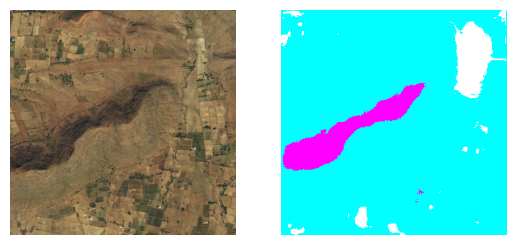

In [26]:
img = cv2.imread("E:\THIRD YEAR\Datasets\deepglobe/train/129298_sat.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
input_tensor = image_transform(img)
input_batch = input_tensor.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(input_batch).squeeze()

_, predicted_labels = torch.max(output, 0)
predicted_mask = predicted_labels.squeeze().cpu().numpy()
print(torch.unique(predicted_labels))

label_map_colors = {0: [0, 255, 255],
 1: [255, 255, 0],
 2: [255, 0, 255],
 3: [0, 255, 0],
 4: [0, 0, 255],
 5: [255, 255, 255],
 6: [0, 0, 0]}

colored_mask = np.zeros((predicted_mask.shape[0], predicted_mask.shape[1], 3), dtype=np.uint8)
for label, color in label_map_colors.items():
    colored_mask[predicted_mask == label] = color

plt.subplot(1, 2, 1)
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(colored_mask)
plt.axis('off')

plt.show()

In [19]:
# mask_transform = transforms.Compose([
#     transforms.ToPILImage(),           # Convert numpy array to PIL Image
#     transforms.Resize((256, 256)),     # Resize masks
#     transforms.ToTensor(),             # Convert mask to tensor
#     transforms.Lambda(lambda x: x.long())  # Ensure mask values are integers
# ])

In [ ]:
print(f"Converted True Labels (class indices): {all_labels}")


Number of images: 803
Number of masks: 803
Label range: 0 to 4
Prediction range: 0 to 5
Label range: 0 to 3
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 4
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 4
Prediction range: 0 to 5
Label range: 0 to 4
Prediction range: 0 to 4
Label range: 0 to 6
Prediction range: 0 to 5
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 5
Prediction range: 0 to 4
Label range: 0 to 5
Prediction range: 0 to 5
Label range: 0 to 4
Prediction range: 0 to 4
Label range: 0 to 4
Prediction range: 0 to 5
Label range:

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



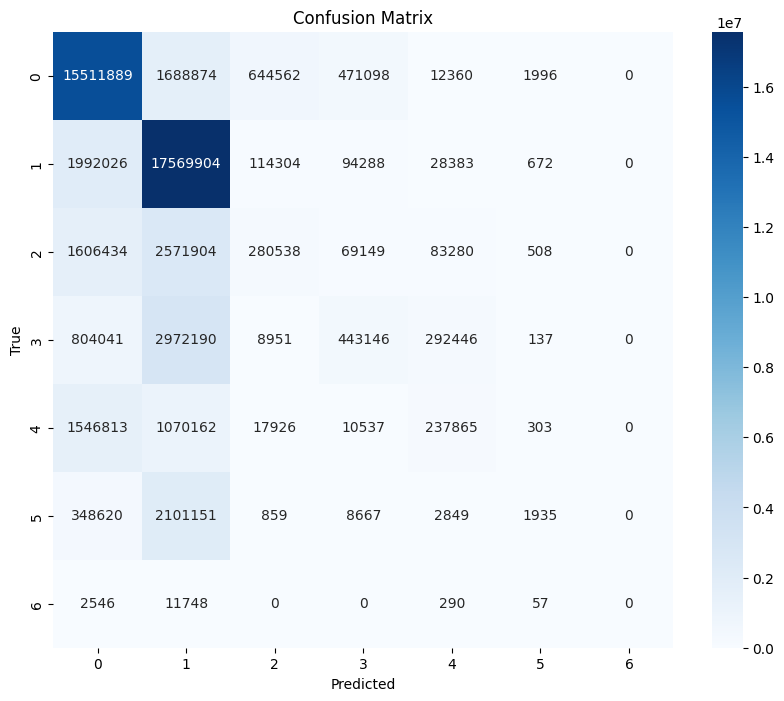

In [15]:
# Current version

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Create reverse label_map to map RGB values to class indices
rgb_to_class = {tuple(value): key for key, value in label_map.items()}

# Define the function to get predictions and labels from the dataloader
def get_predictions_and_labels(dataloader, model, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            
            # Get predictions
            _, preds = torch.max(outputs, 1)
            
            # Convert single-channel true labels to class indices
            labels_np = labels.cpu().numpy().astype(np.int64)  # Convert to int for consistency
            preds_np = preds.cpu().numpy()

            # Debug: Print the range of true labels and predictions
            print(f"Label range: {labels_np.min()} to {labels_np.max()}")
            print(f"Prediction range: {preds_np.min()} to {preds_np.max()}")
            
            # Flatten arrays to simplify confusion matrix computation
            all_preds.extend(preds_np.flatten())
            all_labels.extend(labels_np.flatten())
    
    print(f"True Labels (class indices): {all_labels}")  # Debugging
    return np.array(all_preds), np.array(all_labels)

# Define the function to plot the confusion matrix
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

# Ensure you have a validation dataset (use the correct directory)
valid_dataset = Segmentation_Dataset(TRAIN_DIR, label_map, transform)  # Use VALID_DIR for validation
valid_dataloader = DataLoader(valid_dataset, batch_size=2, shuffle=False)

# Get predictions and true labels
predictions, true_labels = get_predictions_and_labels(valid_dataloader, model, device)

# Compute confusion matrix
num_classes = len(label_map)
cm = confusion_matrix(true_labels, predictions, labels=list(range(num_classes)))

# Plot confusion matrix
plot_confusion_matrix(cm, labels=list(range(num_classes)))